# Парсинг сайтов и анализ текстовой информации
Данные: `irecommend.ru/catalog/list/3769`



## Загрузка модулей и считывание файла

In [ ]:
!pip install pymorphy2

In [10]:
import re
import nltk
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from random import randint
import pymorphy2
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
products_info = []

for page_num in range(0, 30):
    url = f'https://irecommend.ru/catalog/list/3769?page={page_num}'
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    products = soup.find_all('div', class_='ProductTizer plate teaser-item')
    
    for product in products:
        title = product.find('div', class_='title').text
        counter = product.find('span', class_='counter').text
        products_info.append((title, counter))
        
    sleep(randint(8, 11))

In [6]:
df = pd.DataFrame(products_info, columns=['title', 'counter'])
df

,title,counter
0,Средство для прочистки труб GreenGoods,1
1,Салфетки из микрофибры для очистки стекол Fabe...,29
2,Пятновыводитель Большая стирка Гель на основе ...,13
3,"Капсулы для стирки Ariel All in 1 PODS ""горный...",15
4,Гель для мытья посуды EcoLogica с экстрактом...,2
...,...,...
595,Спрей для обуви Faberlic shoe care,2
596,Универсальное чистящее средство для кухни Chis...,3
597,Сменный аэрозольный баллон к автоматическому о...,3
598,Губка для обуви Happy foot comfort & care черная,3



## Разведочный анализ данных и их корректировка

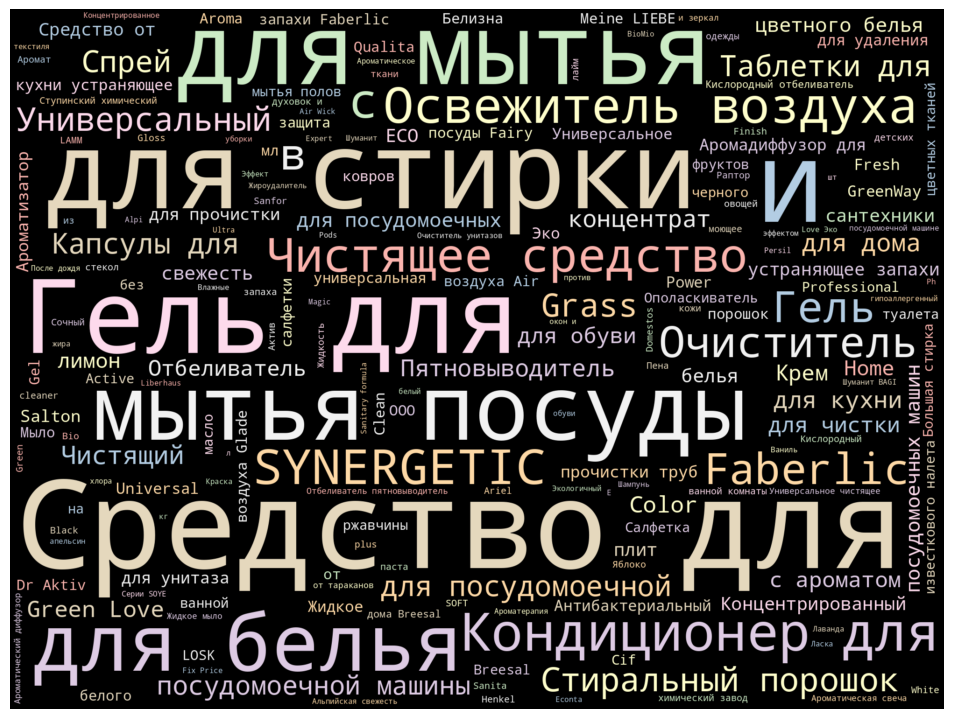

In [7]:
wordcloud = WordCloud(width=2000, height=1500, background_color='black',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Можно заметить насколько часто используется предлог "для" в названиях товаров. Необходимо привести данные к нижнему регистру, почистить от стоп-слов, знаков препинания, одиночных чисел и символов, а также привести к нормальной форме.

In [8]:
morph = pymorphy2.MorphAnalyzer()
stop_words = stopwords.words("russian")

def clean_title_lemmatize(title):
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)
    title = re.sub(r'\b\d+\b', '', title)
    title = re.sub(r'\b\w{1,2}\b', '', title)
    words = word_tokenize(title)
    words = [word for word in words if word not in stop_words]
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmas)

In [11]:
df['title'] = df['title'].apply(clean_title_lemmatize)
df

,title,counter
0,средство прочистка труба greengoods,1
1,салфетка микрофибра очистка стекло faberlic,29
2,пятновыводитель больший стирка гель основа акт...,13
3,капсула стирка ariel all pods горный родник,15
4,гель мытьё посуда ecologica экстракт трава,2
...,...,...
595,спреть обувь faberlic shoe care,2
596,универсальный чистить средство кухня chistol у...,3
597,сменный аэрозольный баллон автоматический осве...,3
598,губка обувь happy foot comfort care чёрный,3


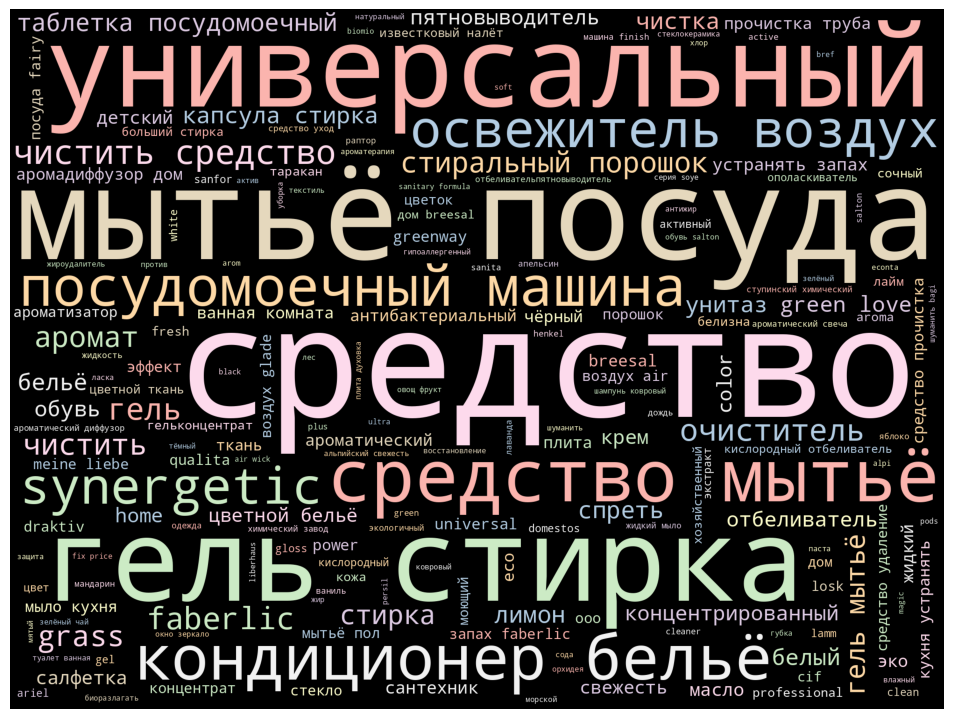

In [12]:
wordcloud = WordCloud(width=2000, height=1500, background_color='black',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Нам удалось обработать текст и выделить наиболее часто встречающиеся темы, которые относятся к бытовой химии. Среди них можно выделить химию, связанную с посудой, а также химию, связанную со стиркой.

Проведем частотный анализ слов

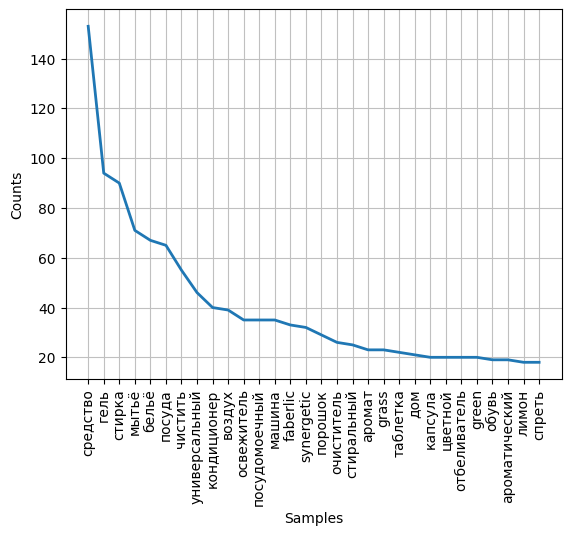

In [13]:
fdist = FreqDist()

for title in df['title']:
    for word in title.split():
        fdist[word] += 1

fdist.plot(30)
plt.show()

Скорее всего, разделение может быть произведено по:

* Средства для стирки
* Средства для мытья посуды
* Очистители
* Освежители воздуха
* Средства для ухода за бельем
* Кондиционеры для белья
* Бренды
* Стиральные машины
* Также все пункты могут быть объединены в одну категорию "Бытовая химия".

## Сравнение алгоритмов TfidVectorizer и CountVectorizer

In [14]:
titles = df['title']

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df['title'])

n_clusters = 10
tfidf_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
tfidf_clusters = tfidf_kmeans.fit_predict(tfidf_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[tfidf_clusters == i])
    print()

Cluster 1:
18     мыло кухня устранять запах faberlic home арома...
55      мыло кухня устранять запах faberlic кофе тирамис
153    мыло кухня устранять запах faberlic серия дом ...
213    мыло кухня устранять запах faberlic весенний ц...
244           жидкий мыло кухня faberlic устранять запах
276                мыло хозяйственный вкусвилл кокосовый
302                             жидкий мыло grass milana
303    мыло кухня устранять запах faberlic бархатный ...
329    мыло кухня устранять запах faberlic цветочный ...
334    мыло хозяйственный невский косметика sarma про...
360    жидкий мыло domix green мятный масло применени...
458    жидкий мыло faberlic кухня устранять запах сла...
501    жидкий мыло faberlic устранять запах цветочноц...
511    мыло хозяйственный мастерская олесь мустаева н...
547      мыло кухня устранять запах faberlic зелёный чай
Name: title, dtype: object

Cluster 2:
2      пятновыводитель больший стирка гель основа акт...
3            капсула стирка ariel all 

In [15]:
count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(titles)

count_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
count_clusters = count_kmeans.fit_predict(count_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[count_clusters == i])
    print()

Cluster 1:
224    удалитель клейка лента клей наклейка prosept d...
Name: title, dtype: object

Cluster 2:
7      стиральный порошокконцентрат astel sportswear ...
17     стиральный порошок synergetic эко суперконцентрат
22     стиральный порошок концентрат faberlic премиум...
27                               стиральный порошок цена
36     стиральный порошок ооо флора урал flora universal
41     стиральный порошок ооо флора урал flora universal
59                              стиральный порошок сарма
65                    чистить порошок sanita эффект сода
113    стиральный порошокконцентрат eco londix универ...
118         стиральный порошок аквасан vera automat 400г
136                      стиральный порошок ушастый няня
152                      чистить порошок greenway mystik
184                     стиральный порошок ооо эколя луч
219                  чистить порошок пемолюкс pro nature
225    стиральный порошокконцентрат wasche meister ав...
252    стиральный порошок meine liebe 

TfidfVectorizer в большинстве случаях всегда будет давать более хорошие результаты, так как он учитывает не только частоту слов, но и их важность в тексте. Примерные его группы разбиения:

1) Мыла (разные)

2) Всё для стирки

3) Всё для мыться посуды

4) Освежитель воздуха

5) Ароматизаторы

6) Средства для мытья стекол и сантехники

7) Товары для стирки

8) Видимо сюда попало все остальное

9) И сюда

10) Для травки тараканов



Хотя CountVectorizer показал результаты не сильно хуже:


1) Тут всего 1 группа - клейкие ленты

2) Стиральные порошки

3) Всё для кухни

4) Всё для стирки

5) Видимо сюда попало все остальное

6) Очистка сантехники

7) Очистка сантехники

8) Кондиционеры для белья

9) Освежитель воздуха

10) Мытье стекол и посуды

Провизуализируем разбиение алгоритмами

In [16]:
def make_cooccurrence_matrix(texts):
  # Зададим словарь и попарную частоту совместной встречаемости слов
  vocabulary = set(texts[0].split())
  for t in texts[1:]:
    vocabulary = vocabulary.union(set(t.split()))
  vocabulary=list(vocabulary)

  N = len(vocabulary)
  
  # Задаём cooccurrence matrix
  cooccurrence = np.zeros((N,N))
  for i in range(N):
    for j in range(i, N):
      if i == j:
        continue
      for t in texts:
        if vocabulary[i] in t.split() and vocabulary[j] in t.split():
          cooccurrence[i][j]+=1
          cooccurrence[j][i]+=1
  return cooccurrence, vocabulary

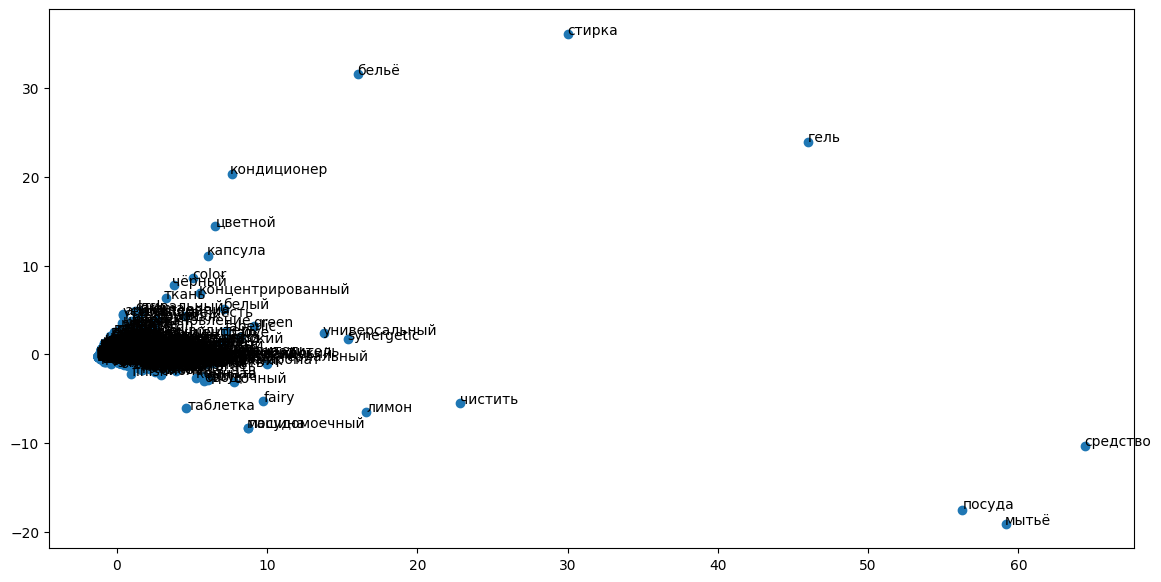

In [17]:
text_list = df['title'].tolist()

c, v = make_cooccurrence_matrix(text_list)

p = PCA(n_components=2)
pca = p.fit_transform(c)

plt.figure(figsize=(14,7))
ax = plt.gca()
for i, c in enumerate(pca):
    ax.annotate(text = v[i], xy = (c[0] + np.random.randn()/15, c[1]+ np.random.randn()/15))
plt.scatter(pca[:,0], pca[:,1])
plt.show()

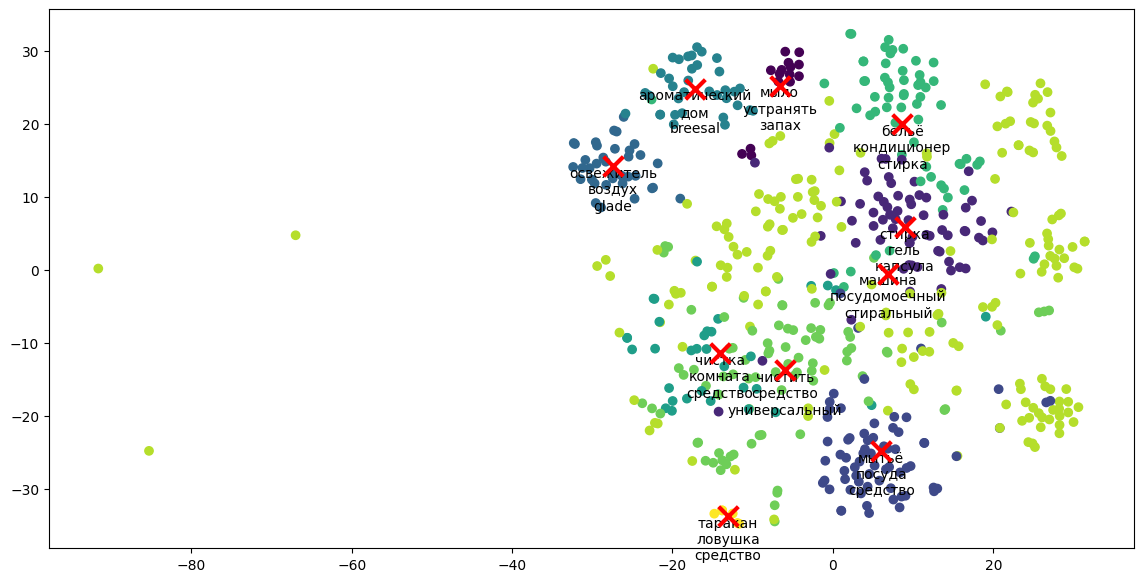

In [18]:
tsne = TSNE(n_components=2)
reduced_vectors = tsne.fit_transform(tfidf_vectors.toarray())

centroids = np.zeros((n_clusters, 2))
for i in range(n_clusters):
    centroids[i] = np.mean(reduced_vectors[tfidf_clusters == i], axis=0)

plt.figure(figsize=(14, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=tfidf_clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r', zorder=10)

for i in range(n_clusters):
    cluster_words = tfidf_vectors[tfidf_clusters == i].toarray().sum(axis=0)
    top_words_indices = cluster_words.argsort()[-3:][::-1]
    top_words = [tfidf_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
    plt.annotate('\n'.join(top_words), (centroids[i, 0], centroids[i, 1]), ha='center', va='top')

plt.show()

### Подсчёт характеристик

In [19]:
df['counter'] = df['counter'].astype(int)

df['cluster'] = tfidf_clusters

In [20]:
title_count = df.groupby('cluster')['title'].count()

sum_counts = df.groupby('cluster')['counter'].sum()

stats_df = pd.concat([title_count, sum_counts], axis=1)
stats_df.columns = ['title_count', 'sum_counts']

stats_df

,title_count,sum_counts
cluster,,
0,15,344
1,67,1070
2,68,3357
3,36,305
4,35,150
5,34,735
6,63,632
7,85,2652
8,191,3681


Исходя из таблицы, можно сделать вывод, что товары из 2-го и 8-го кластера, связанные со средствами для стирки, наиболее популярны и пользуются наибольшей популярностью среди пользователей. Кластеры 1 (мыло) и 7 (средства для мытья сантехники и стирки) также имеют довольно большое количество отзывов, что свидетельствует о высоком спросе на товары данных категорий. Кластеры 5 (ароматизаторы) и 6 (чистка сантехники) имеют меньшее количество отзывов, что может говорить о более узкой аудитории потребителей. Остальные кластеры имеют еще меньшее количество отзывов, что может говорить о том, что данные товары пользуются меньшей популярностью или имеют более узкую целевую аудиторию.